In [1]:
grid_shape = (7, 10)  # y, x
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

start_pos = np.array((3, 0))
end_pos = np.array((3, 7))
grid = np.zeros(grid_shape)
grid[*start_pos] = 1
grid[*end_pos] = 2
wind_columns = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]


# plotting funcs
def plot_grid(ax: plt.axes = None):
    cmap = ListedColormap(["white", "#6a994e", "#bc4749"])

    if ax:
        plt.imshow(grid, extent=[0, 10, 0, 7], cmap=cmap, ax=ax)
    else:
        plt.imshow(grid, extent=[0, 10, 0, 7], cmap=cmap)

    # add text annotations
    plt.text(
        start_pos[1] + 0.5,
        start_pos[0] + 0.5,
        "S",
        color="black",
        fontsize=12,
        ha="center",
        va="center",
    )
    plt.text(
        end_pos[1] + 0.5,
        end_pos[0] + 0.5,
        "E",
        color="black",
        fontsize=12,
        ha="center",
        va="center",
    )

    x_ticks = np.arange(
        grid_shape[1] + 1
    )  # From -0.5 to max x, stepping by 1 to align with cell boundaries
    x_labels = np.arange(
        grid_shape[1] + 1
    )  # Optional: numerical labels from 0 to max x
    plt.xticks(x_ticks, labels=x_labels, minor=False)  # Set x-ticks

    # add labels for the wind values
    wind_vals = np.arange(0.5, grid_shape[1] + 0.5, 1)
    plt.xticks(wind_vals, wind_columns, minor=True)
    plt.tick_params(axis="x", which="minor", length=0, pad=30)

    plt.grid(which="major", c="black")


def plot_state(state: tuple[int, int]) -> None:
    plot_grid()
    loc = np.array(state)[::-1] + 0.5
    agent_vis = plt.Circle(loc, 0.2, color="#1e6091")

    ax = plt.gca()

    ax.add_patch(agent_vis)


def plot_path(path: np.ndarray, alpha=1.0):
    plt.plot(path[:, 1] + 0.5, path[:, 0] + 0.5, c="black", linestyle="-", alpha=alpha)

# TD Control

In [2]:
# Algorithm parameters: step size ↵ 2 (0, 1], small " > 0
# Initialize Q(s, a), for all s c S+, a c A(s), arbitrarily except that Q(terminal, ·)=0
# Loop for each episode:
#   Initialize S
#   Choose A from S using policy derived from Q (e.g., eps-greedy)
#   Loop for each step of episode:
#     Take action A, observe R, S'
#     Choose A' from S' using policy derived from Q (e.g., eps-greedy)
#     Q(S, A) Q(S, A) + R + Q(S', A') - Q(S, A)
#     S <- S'; A <- A'
#   until S is terminal

## Recreating the textbook environment

In [3]:
# fmt: off
# normal actions
A = np.array(
    [
        ( 1,  0),
        (-1,  0),
        ( 0,  1),
        ( 0, -1),
    ]
)
# fmt: on

epsilon = 0.1
alpha = 0.5
num_actions = len(A)
state_dims = (grid_shape) + (num_actions, ) # y, x, |A|
Q = np.random.random(size=state_dims)
Q[*end_pos, :] = 0 # set the terminal states to have value 0

a_max = np.array(grid.shape) - 1
def take_action(S: np.ndarray, action: np.ndarray) -> tuple[bool, int, np.ndarray]:
    # take the action (move the state)
    S_prime = S + action
    # apply the effect of wind
    wind_effect = wind_columns[S[1]]
    S_prime[0] += wind_effect
    # clip at boundaries
    S_prime = np.clip(S_prime, a_min=0, a_max=a_max)
    # check if the position is terminal. If yes, return 0 reward, otherwise return -1
    if all(S_prime == end_pos):
        terminated = True
        R = 0
    else:
        terminated = False
        R = -1
    return terminated, R, S_prime

def policy(S, Q) -> None:
    if np.random.rand() < epsilon:
        # pick a random policy
        return np.random.randint(0, num_actions)
    else:
        # pick the greedy policy
        return np.argmax(Q[*S])
    
eps_finished = 0
eps_fin_count = []
num_episodes = 500
for _ in range(num_episodes):
    S = start_pos
    # policy
    a = policy(S, Q)
    terminated = False
    states = [S]
    while not terminated:
        action = A[a]
        terminated, R, S_prime = take_action(S, action)
        a_prime = policy(S_prime, Q)
        Q[*S, a] += alpha * (R + Q[*S_prime, a_prime] - Q[*S, a])
        S = S_prime
        a = a_prime
        states.append(S)
        eps_fin_count.append(eps_finished)
    eps_finished += 1

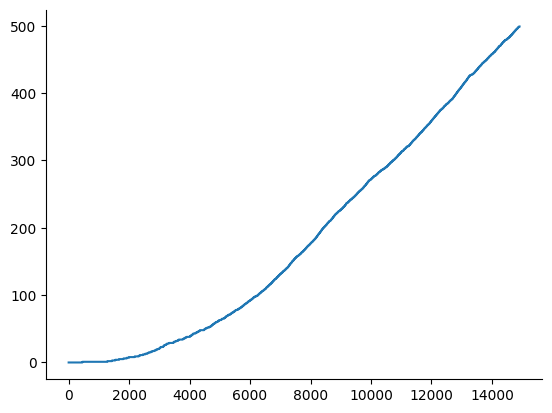

In [4]:
plt.plot(eps_fin_count)  # looks familiar!
plt.gca().spines["top"].set_visible(False)  # Hide the top spine
plt.gca().spines["right"].set_visible(False)  # Hide the right spine
plt.show()

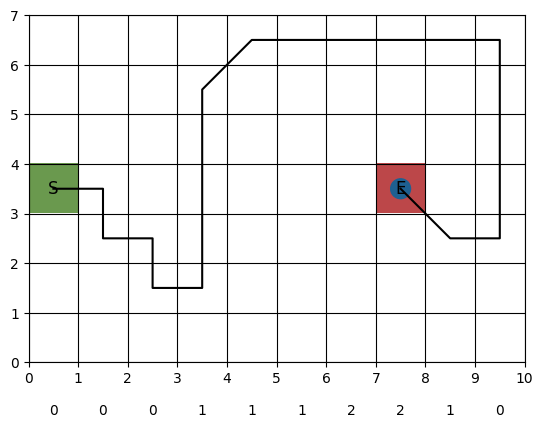

In [5]:
plot_state(end_pos)
plot_path(np.array(states))

## King's Moves

In [6]:
# fmt: off
# King's moves adds diagonal options
A = np.array(
    [
        ( 1,  0),
        (-1,  0),
        ( 0,  1),
        ( 0, -1),
        (-1, -1),
        (-1,  1),
        ( 1, -1),
        ( 1,  1),
    ]
)
# fmt: on

epsilon = 0.1
alpha = 0.5
num_actions = len(A)
state_dims = (grid_shape) + (num_actions, ) # y, x, |A|
Q = np.random.random(size=state_dims)
Q[*end_pos, :] = 0 # set the terminal states to have value 0
    
num_episodes = 500
for _ in range(num_episodes):
    S = start_pos
    # policy
    a = policy(S, Q)
    terminated = False
    states = [S]
    while not terminated:
        action = A[a]
        terminated, R, S_prime = take_action(S, action)
        a_prime = policy(S_prime, Q)
        Q[*S, a] += alpha * (R + Q[*S_prime, a_prime] - Q[*S, a])
        S = S_prime
        a = a_prime
        states.append(S)

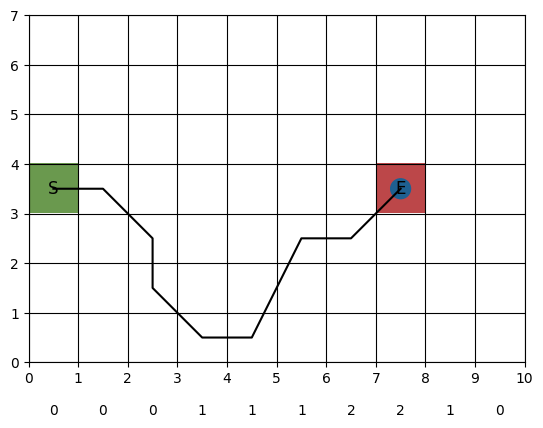

In [7]:
plot_state(end_pos)
plot_path(
    np.array(states)
)  # this is already optimal - the policy only moves rightwards, so adding another action will have no effect

## Stochastic Winds
In this variant, the wind applies randomly, with 1/3rd chances of applying -1, +0, or +1 to the true wind. For example, if the true wind is 3, the wind can be 2, 3, or 4.

In [8]:
# fmt: off
# King's moves
A = np.array(
    [
        ( 1,  0),
        (-1,  0),
        ( 0,  1),
        ( 0, -1),
        (-1, -1),
        (-1,  1),
        ( 1, -1),
        ( 1,  1),
        ( 0,  0) # add the stationary move
    ]
)
# fmt: on

epsilon = 0.1
alpha = 0.5
num_actions = len(A)
state_dims = (grid_shape) + (num_actions, ) # y, x, |A|
Q = np.random.random(size=state_dims)
Q[*end_pos, :] = 0 # set the terminal states to have value 0

# define a new take_action that accounts for stochastic wind
def take_action_stochastic(S: np.ndarray, action: np.ndarray) -> tuple[bool, int, np.ndarray]:
    # take the action (move the state)
    S_prime = S + action
    # apply the effect of wind
    wind_effect = wind_columns[S[1]]
    
    if wind_effect != 0: # stochastic effect only occurs where there's wind
        wind_effect += np.random.randint(-1, 2) # -1, 0, +1

    S_prime[0] += wind_effect
    # clip at boundaries
    S_prime = np.clip(S_prime, a_min=0, a_max=a_max)
    # check if the position is terminal. If yes, return 0 reward, otherwise return -1
    if all(S_prime == end_pos):
        terminated = True
        R = 0
    else:
        terminated = False
        R = -1
    return terminated, R, S_prime

    
eps_finished = 0
eps_fin_count = []
num_episodes = 10_000
for _ in range(num_episodes):
    S = start_pos
    # policy
    a = policy(S, Q)
    terminated = False
    states = [S]
    while not terminated:
        action = A[a]
        terminated, R, S_prime = take_action_stochastic(S, action)
        a_prime = policy(S_prime, Q)
        Q[*S, a] += alpha * (R + Q[*S_prime, a_prime] - Q[*S, a])
        S = S_prime
        a = a_prime
        states.append(S)
        eps_fin_count.append(eps_finished)
    eps_finished += 1

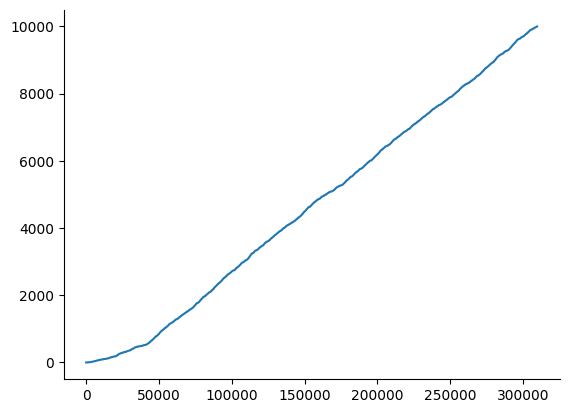

In [9]:
plt.plot(eps_fin_count)  # looks familiar!
plt.gca().spines["top"].set_visible(False)  # Hide the top spine
plt.gca().spines["right"].set_visible(False)  # Hide the right spine
plt.show()

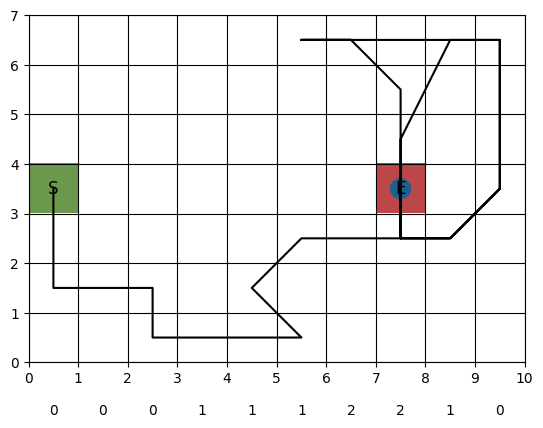

In [10]:
plot_state(end_pos)
plot_path(
    np.array(states)
)  # this is already optimal - the policy only moves rightwards, so adding another action will have no effect

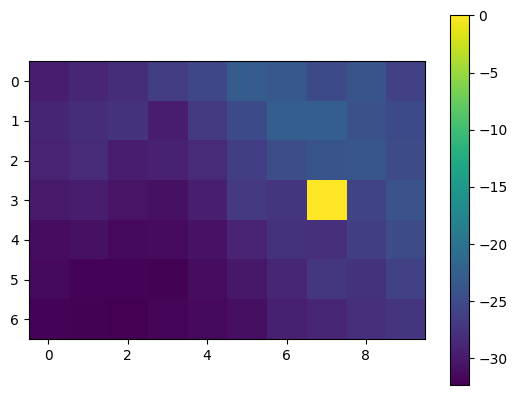

In [11]:
plt.imshow(Q.mean(axis=2))
plt.colorbar()
plt.show()

In [12]:
def plot_grid_anim(ax: plt.Axes):
    cmap = ListedColormap(["white", "#6a994e", "#bc4749"])

    ax.imshow(grid, extent=[0, 10, 0, 7], cmap=cmap)

    # add text annotations
    ax.text(
        start_pos[1] + 0.5,
        start_pos[0] + 0.5,
        "S",
        color="black",
        fontsize=12,
        ha="center",
        va="center",
    )
    ax.text(
        end_pos[1] + 0.5,
        end_pos[0] + 0.5,
        "E",
        color="black",
        fontsize=12,
        ha="center",
        va="center",
    )

    x_ticks = np.arange(
        grid_shape[1] + 1
    )  # From -0.5 to max x, stepping by 1 to align with cell boundaries
    x_labels = np.arange(
        grid_shape[1] + 1
    )  # Optional: numerical labels from 0 to max x
    ax.set_xticks(x_ticks, labels=x_labels, minor=False)  # Set x-ticks

    # add labels for the wind values
    wind_vals = np.arange(0.5, grid_shape[1] + 0.5, 1)
    ax.set_xticks(wind_vals, wind_columns, minor=True)
    ax.tick_params(axis="x", which="minor", length=0, pad=30)

    ax.grid(which="major", c="black")


def plot_state_anim(state: tuple[int, int], ax: plt.Axes) -> None:
    loc = np.array(state)[::-1] + 0.5
    agent_vis = plt.Circle(loc, 0.2, color="#1e6091")

    ax.add_patch(agent_vis)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


# Assuming plot_state and plot_path are defined elsewhere and states is available
def create_anim(states):
    fig, ax = plt.subplots()  # Create a figure and an axes

    def update(frame) -> None:
        ax.clear()  # Clear previous drawings
        plot_grid_anim(ax)
        plot_state_anim(states[frame], ax)
        path = np.array(states[: frame + 1])
        ax.plot(
            path[:, 1] + 0.5, path[:, 0] + 0.5, c="black", linestyle="-", alpha=alpha
        )

    # # Create animation
    ani = FuncAnimation(fig, update, frames=len(states), interval=250)
    return ani

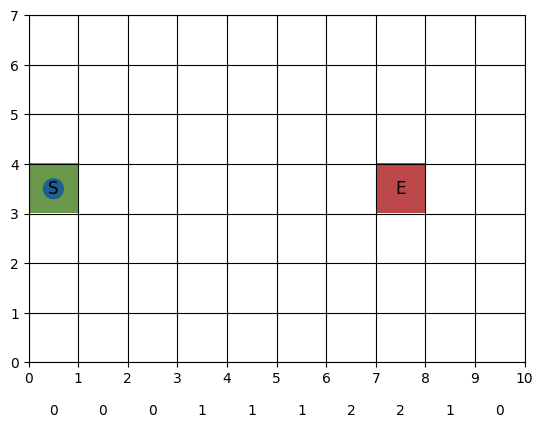

In [15]:
from IPython.display import HTML

ani = create_anim(states)
HTML(ani.to_jshtml())